##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix：使用条件 GAN 进行图像到图像的转换

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/pix2pix"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/pix2pix.ipynb">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">     在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/pix2pix.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/pix2pix.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示了如何构建和训练一个名为 pix2pix 的条件生成对抗网络 (cGAN)，该网络学习从输入图像到输出图像的映射，如 Isola 等人在 [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004){:.external} （2017 年）中所述 。pix2pix 非特定于应用，它可以应用于多种任务，包括从标签地图合成照片，从黑白图像生成彩色照片，将 Google Maps 照片转换为航拍图像，甚至将草图转换为照片。

在此示例中，您的网络将使用[布拉格捷克理工大学](http://cmp.felk.cvut.cz/~tylecr1/facade/){:.external}的[机器感知中心](http://cmp.felk.cvut.cz/){:.external}提供的 [CMP Facade Database](https://www.cvut.cz/) 来生成建筑立面。为了简化示例，您将使用由 pix2pix 作者创建的此数据集的[预处理副本](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}。

在 pix2pix cGAN 中，您可以对输入图像进行调节并生成相应的输出图像。cGAN 最初在 [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014) 中提出。

您的网络架构将包含：

- 基于 [U-Net](https://arxiv.org/abs/1505.04597){:.external} 架构的生成器。
- 由卷积 PatchGAN 分类器表示的判别器（在 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中提出）。

请注意，在单个 V100 GPU 上，每个周期可能需要大约 15 秒。

以下是 pix2pix cGAN 在 Facade Database（8 万步）上训练 200 个周期后生成的一些输出示例。

![sample output_1](https://tensorflow.google.cn/images/gan/pix2pix_1.png) ![sample output_2](https://tensorflow.google.cn/images/gan/pix2pix_2.png)

## 导入 TensorFlow 和其他库

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import os
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt

In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
print(f"当前工作目录: {os.getcwd()}")

当前工作目录: /content/drive/MyDrive/Colab Notebooks


In [6]:
# 列出当前目录中的所有文件
files = os.listdir('.')
print("当前目录中的文件：")
print(files)

当前目录中的文件：
['Untitled (2)', '“cee690_hw3_template.ipynb”的副本 (1)', '“cee690_hw3_template.ipynb”的副本', 'CS4342_Final_Project(1) (1).ipynb', 'Untitled1.ipynb', 'CS4342_Final_Project(1).ipynb', 'Untitled (1)', 'Pybullet_Learn.ipynb', 'hw1_LMS', 'SimpleNN.ipynb', 'LabRNN-2.ipynb', 'HW4_lab1.ipynb', 'Untitled2.ipynb', 'hw4.ipynb', '“pix2pix.ipynb”的副本 (2)', '“pix2pix.ipynb”的副本 (1)', 'pix2pix_GAN (1).ipynb', 'Untitled', '“pix2pix.ipynb”的副本', 'HWK5_main.ipynb', 'efficientnetv2-emotion-recognition.ipynb', 'pix2pix.ipynb', 'pix2pix_GAN.ipynb', 'logs', 'training_checkpoints', 'testdataset_predict_result', 'testdataset_predict_ground_truth', 'testdataset_predict_result_attacked', 'testdataset_predict_ground_truth_attacked', 'training_checkpoints_attacked', 'logs_attacked', 'images_dataset', 'images_dataset_attacked', 'Evaluation_PSNR_SSIM_FID_12_7.ipynb', 'evaluation_results.txt', 'Evaluation_PSNR_SSIM_FID_attacked_12_7.ipynb', 'model.png', 'generator_loss_plot.png', 'discriminator_loss_plot.png', 'p

In [7]:
PATH = 'images_dataset_attacked'  # 请替换为您的数据集实际路径

In [8]:
# !unzip images_dataset.zip

## 加载数据集

下载 CMP Facade Database 数据 (30MB)。可在[这里](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}以相同格式获得其他数据集。在 Colab 中，您可以从下拉菜单中选择其他数据集。请注意，其他一些数据集要大得多（`edges2handbags` 为 8GB）。

In [9]:
# 检查数据集中的图片数量
image_files = tf.io.gfile.glob(PATH + '/*.jpg')
image_count = len(image_files)
print(f"总共有 {image_count} 张图片")


总共有 300 张图片


In [10]:
# 指定特殊的图片
special_image = os.path.join(PATH, 'combined_attacked_1.jpg')

# 确保指定图片存在于数据集
if special_image not in image_files:
    raise ValueError(f"指定的图片 {special_image} 不在数据集 {PATH} 中。")

# 将特殊图片从原始列表中移除
image_files.remove(special_image)

In [11]:
# 4. 划分训练集和测试集（80% 训练，20% 测试）
train_size = int(0.8 * image_count)
train_files = image_files[:train_size]
test_files = image_files[train_size:]

# 将特殊图片加入测试集
test_files.append(special_image)


# 创建 TensorFlow 数据集
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)


每个原始图像的大小为 `256 x 512`，包含两个 `256 x 256` 图像：

In [12]:
# sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
# sample_image = tf.io.decode_jpeg(sample_image)
# print(sample_image.shape)

In [13]:
# plt.figure()
# plt.imshow(sample_image)

您需要将真实的建筑立面图像与建筑标签图像分开，所有这些图像的大小都是 `256 x 256`。

定义加载图像文件并输出两个图像张量的函数：

In [14]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)
  w = tf.shape(image)[1]
  w = w // 2
  # 左边是输入，右边是目标
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image


绘制输入图像（建筑标签图像）和真实（建筑立面照片）图像的样本：

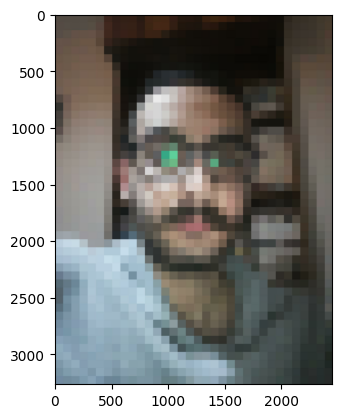

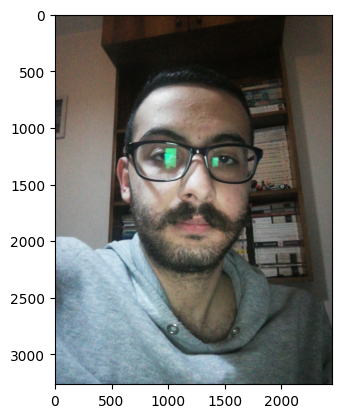

In [15]:
inp, re = load("images_dataset_attacked/combined_attacked_1.jpg")
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述，您需要应用随机抖动和镜像来预处理训练集。

定义几个具有以下功能的函数：

1. 将每个 `256 x 256` 图像调整为更大的高度和宽度，`286 x 286`。
2. 将其随机裁剪回 `256 x 256`。
3. 随机水平翻转图像，即从左到右（随机镜像）。
4. 将图像归一化到 `[-1, 1]` 范围。

In [16]:
# The facade training set consist of 400 images
BUFFER_SIZE = 300 #更改
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [17]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [18]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [19]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [20]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

您可以检查部分预处理输出：

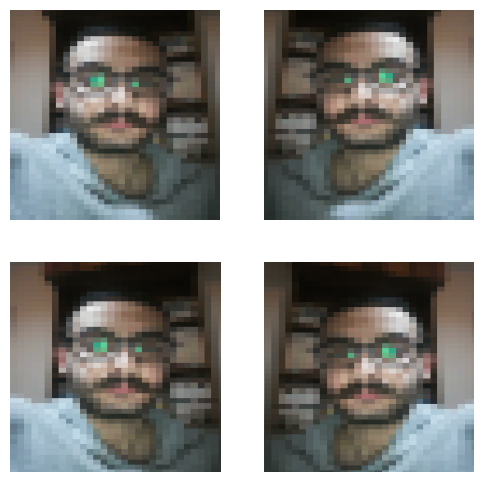

In [21]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

检查加载和预处理能够正常工作后，我们来定义两个辅助函数来加载和预处理训练集和测试集：

In [22]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [23]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## 使用 `tf.data` 构建输入流水线

In [24]:
train_dataset = tf.data.Dataset.list_files(str(PATH + '/*.jpg'))

train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [25]:
# # 8. 处理训练集
# train_dataset = train_dataset.map(load_image_train,
#                                   num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# train_dataset = train_dataset.batch(BATCH_SIZE)

# 9. 处理测试集
test_dataset = test_dataset.map(load_image_test,
                                num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [26]:
# # try:
# #   test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
# # except tf.errors.InvalidArgumentError:
# #   test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
# test_dataset = test_dataset.map(load_image_test)
# test_dataset = test_dataset.batch(BATCH_SIZE)

## 构建生成器

您的 pix2pix cGAN 是*经过修改的* [U-Net](https://arxiv.org/abs/1505.04597){:.external}。U-Net 由编码器（下采样器）和解码器（上采样器）。（有关详细信息，请参阅[图像分割](../images/segmentation.ipynb)教程和 [U-Net 项目网站](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}。）

- 编码器中的每个块为：Convolution -&gt; Batch normalization -&gt; Leaky ReLU
- 解码器中的每个块为：Transposed convolution -&gt; Batch normalization -&gt; Dropout（应用于前三个块）-&gt; ReLU
- 编码器和解码器之间存在跳跃连接（如在 U-Net 中）。

定义下采样器（编码器）：

In [27]:
OUTPUT_CHANNELS = 3

In [28]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [29]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 1632, 1224, 3)


定义上采样器（解码器）：

In [30]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [31]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 3264, 2448, 3)


使用下采样器和上采样器定义生成器：

In [32]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

可视化生成器模型架构：

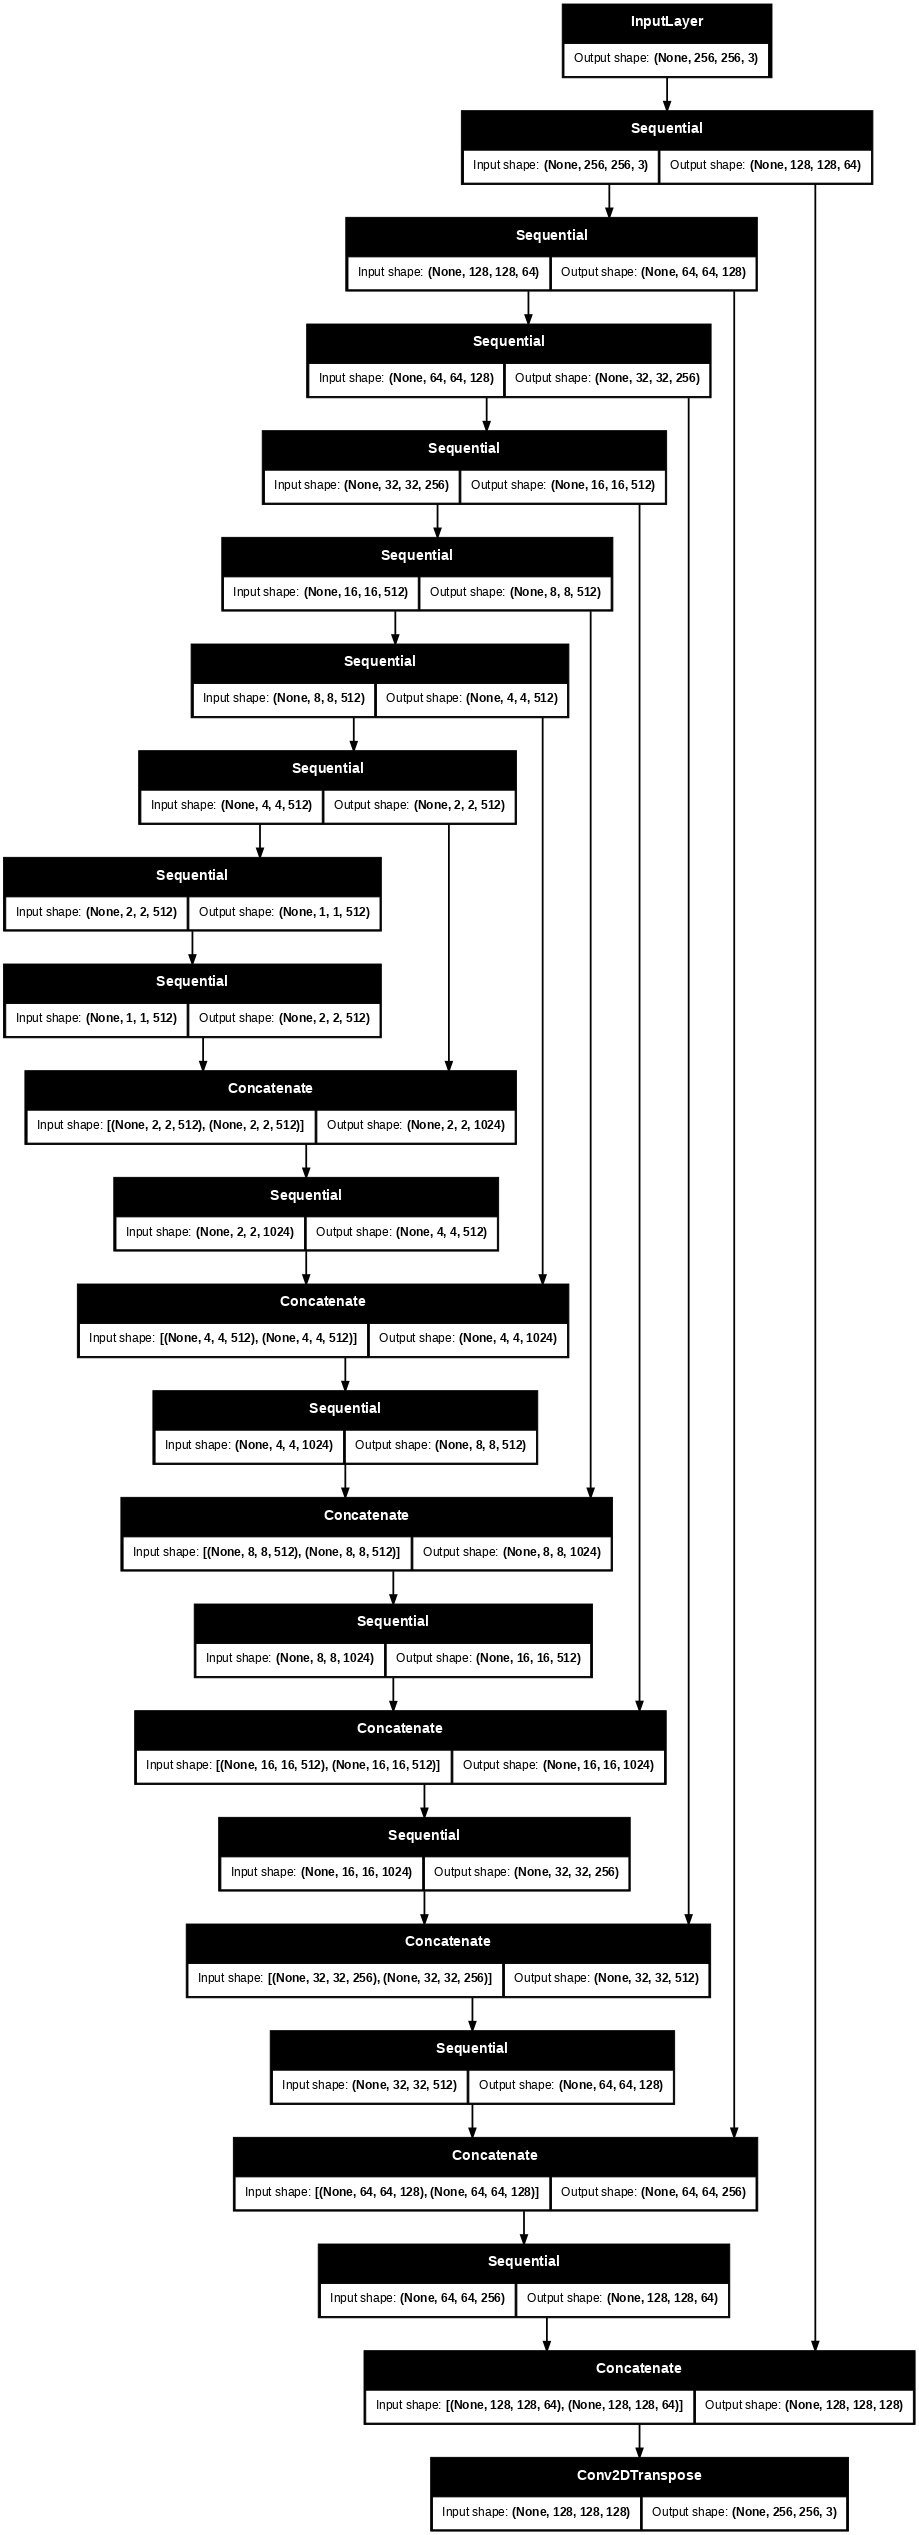

In [33]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

测试生成器：

In [34]:
#This cell is used to try to solve input image size problem


# 假设你想测试的图像文件路径是 "images_dataset/combined_1.jpg"
test_input, test_real = load_image_test("images_dataset/combined_1.jpg")

# 检查预处理后的图像尺寸
print("Test Input Shape:", test_input.shape)  # 应该是 (256, 256, 3)
print("Test Real Shape:", test_real.shape)    # 应该是 (256, 256, 3)

test_input_batch = test_input[tf.newaxis, ...]

Test Input Shape: (256, 256, 3)
Test Real Shape: (256, 256, 3)


Generated Output Shape: (1, 256, 256, 3)


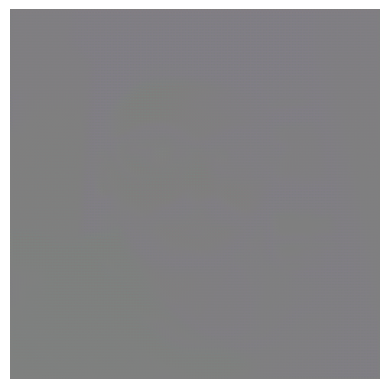

In [35]:
#This cell is used to try to solve input image size problem

gen_output = generator(test_input_batch, training=False)
print("Generated Output Shape:", gen_output.shape)

# 可视化生成的图像
plt.imshow((gen_output[0] + 1) / 2)  # 反归一化到 [0, 1] 范围
plt.axis('off')
plt.show()

In [36]:
#This cell is the original cell for 测试生成器：,but has an image size problem. given the size which hasn't be resized

# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

### 定义生成器损失

GAN 学习适应数据的损失，而 cGAN 学习结构化损失，该损失会惩罚与网络输出和目标图像不同的可能结构，如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述。

- 生成器损失是生成图像和**一数组**的 sigmoid 交叉熵损失。
- <a>论文</a>还提到了 L1 损失，它是生成图像与目标图像之间的 MAE（平均绝对误差）。
- 这样可使生成的图像在结构上与目标图像相似。
- 计算总生成器损失的公式为：`gan_loss + LAMBDA * l1_loss`，其中 `LAMBDA = 100`。该值由论文作者决定。

In [37]:
LAMBDA = 100

In [38]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [39]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

生成器的训练过程如下：

![生成器更新图像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## 构建判别器

pix2pix cGAN 中的判别器是一个卷积 PatchGAN 分类器，它会尝试对每个图像*分块*的真实与否进行分类，如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述。

- 判别器中的每个块为：Convolution -&gt; Batch normalization -&gt; Leaky ReLU。
- 最后一层之后的输出形状为 `(batch_size, 30, 30, 1)`。
- 输出的每个 `30 x 30` 图像分块会对输入图像的 `70 x 70` 部分进行分类。
- 判别器接收 2 个输入：
    - 输入图像和目标图像，应分类为真实图像。
    - 输入图像和生成图像（生成器的输出），应分类为伪图像。
    - 使用`tf.concat([inp, tar], axis=-1)` 将这 2 个输入连接在一起。

我们来定义判别器：

In [40]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

可视化判别器模型架构：

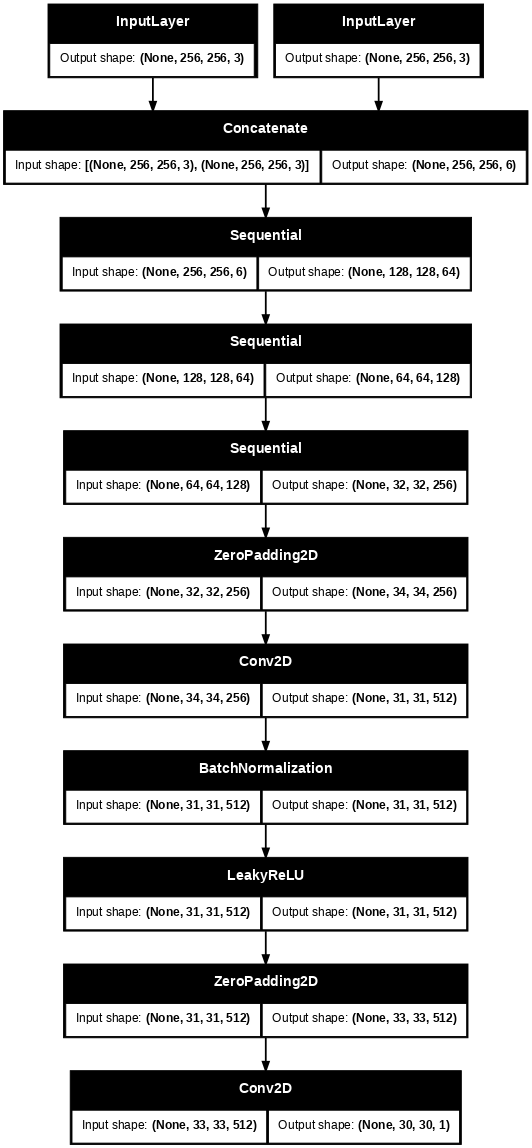

In [41]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

测试判别器：

Test Input Shape: (256, 256, 3)
Test Real Shape: (256, 256, 3)
Test Input Batch Shape: (1, 256, 256, 3)
Generated Output Shape: (1, 256, 256, 3)


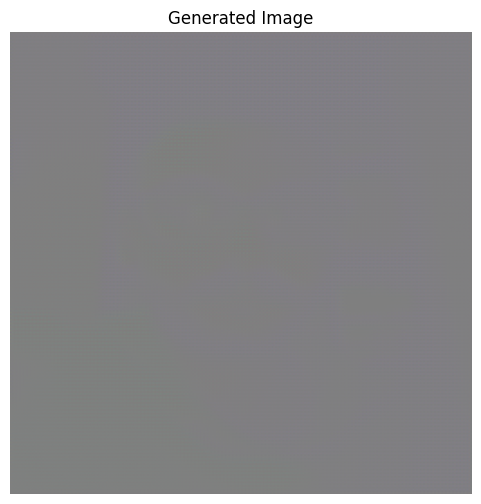

Discriminator Output Shape: (1, 30, 30, 1)
Discriminator Output Values: min = -0.05120251700282097, max = 0.041192427277565


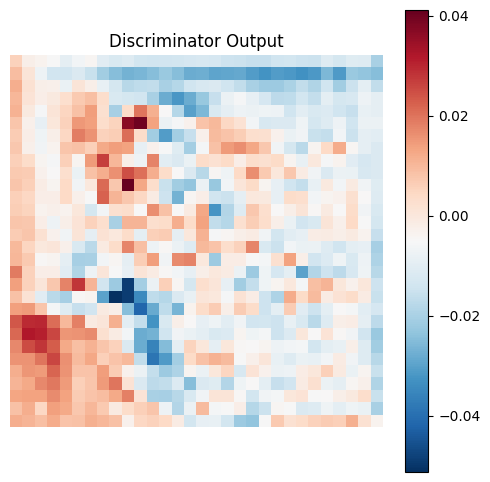

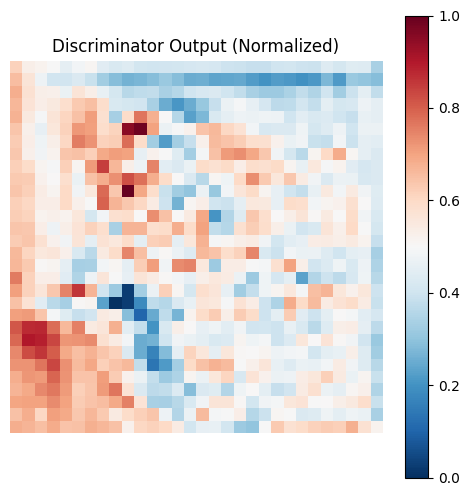

In [42]:
#Dont be afraid! its just atest for discriminator!




# 假设 'load_image_test' 已经定义并返回 (256, 256, 3) 的张量
test_input, test_real = load_image_test("images_dataset/combined_1.jpg")

# 检查预处理后的图像尺寸
print("Test Input Shape:", test_input.shape)  # 应该是 (256, 256, 3)
print("Test Real Shape:", test_real.shape)    # 应该是 (256, 256, 3)

# 添加批次维度
test_input_batch = tf.expand_dims(test_input, axis=0)  # 形状: (1, 256, 256, 3)
print("Test Input Batch Shape:", test_input_batch.shape)  # 应该是 (1, 256, 256, 3)

# 通过生成器生成输出
gen_output = generator(test_input_batch, training=False)
print("Generated Output Shape:", gen_output.shape)  # 应该是 (1, 256, 256, 3)

# 可视化生成的图像
plt.figure(figsize=(6, 6))
plt.imshow((gen_output[0] + 1) / 2)  # 反归一化到 [0, 1] 范围
plt.axis('off')
plt.title("Generated Image")
plt.show()

# 调用判别器，传递输入图像和生成的图像
disc_out = discriminator([test_input_batch, gen_output], training=False)
print("Discriminator Output Shape:", disc_out.shape)  # 应该是 (1, 30, 30, 1)

# 检查判别器输出的值范围
disc_out_min = tf.reduce_min(disc_out).numpy()
disc_out_max = tf.reduce_max(disc_out).numpy()
print(f"Discriminator Output Values: min = {disc_out_min}, max = {disc_out_max}")

# 可视化判别器的输出（自动缩放）
plt.figure(figsize=(6, 6))
plt.imshow(disc_out[0, ..., 0], cmap='RdBu_r')  # 使用第一个通道
plt.colorbar()
plt.title("Discriminator Output")
plt.axis('off')
plt.show()

# 或者，标准化后可视化
disc_out_normalized = (disc_out - disc_out_min) / (disc_out_max - disc_out_min)
plt.figure(figsize=(6, 6))
plt.imshow(disc_out_normalized[0, ..., 0], cmap='RdBu_r')
plt.colorbar()
plt.title("Discriminator Output (Normalized)")
plt.axis('off')
plt.show()


In [43]:
# #original discriminator test code
# disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

### 定义判别器损失

- `discriminator_loss` 函数接收 2 个输入：**真实图像**和**生成图像**。
- `real_loss` 是**真实图像**和**一组 1的 sigmoid 的交叉熵损失（因为这些是真实图像）**。
- `generated_loss` 是**生成图像**和**一组 0 的 sigmoid 交叉熵损失（因为这些是伪图像）**。
- `total_loss` 是 `real_loss` 和 `generated_loss` 的总和

In [44]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

判别器的训练过程如下所示。

要详细了解架构和超参数，请参阅 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}。

![判别器更新图像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## 定义优化器和检查点 saver


In [45]:
generator_optimizer = tf.keras.optimizers.Adam(2e-6, beta_1=0.5)  #initial 2e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-6, beta_1=0.5) #initial 2e-4

In [46]:
checkpoint_dir = './training_checkpoints_attacked'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 生成图像

编写函数以在训练期间绘制一些图像。

- 将图像从测试集传递到生成器。
- 然后，生成器会将输入图像转换为输出。
- 最后一步是绘制预测，*瞧*！

注：在这里，`training=True` 是有意的，因为在基于测试数据集运行模型时，您需要批次统计信息。如果您使用 training = False，将获得从训练数据集中学习的累积统计信息（您不需要）。

In [47]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

测试该函数：

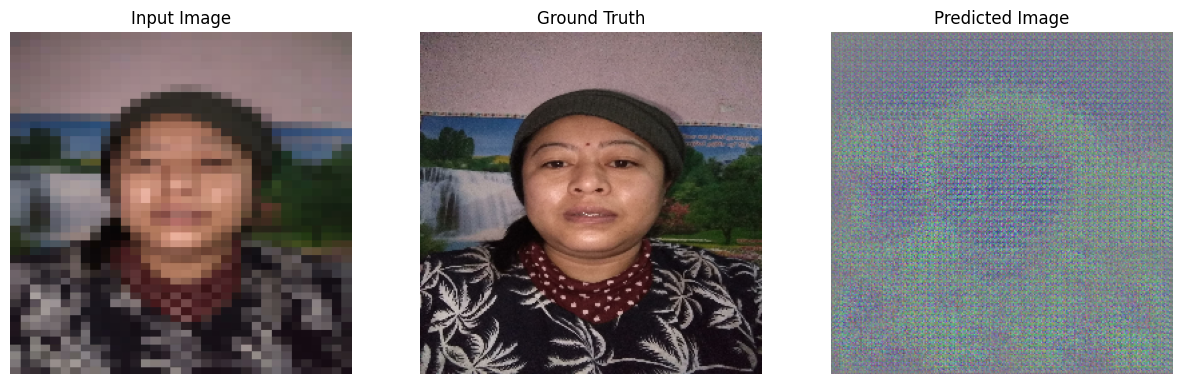

In [48]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## 训练

- 为每个样本输入生成一个输出。
- 判别器接收 input_image 和生成的图像作为第一个输入。第二个输入为 input_image 和 target_image。
- 接下来，计算生成器和判别器损失。
- 随后，计算损失相对于生成器和判别器变量（输入）的梯度，并将其应用于优化器。
- 最后，将损失记录到 TensorBoard。

In [49]:
log_dir="logs_attacked/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [50]:
# 在fit函数外定义全局列表或在fit中定义局部列表 画图用的，用这个不用底下的
gen_total_loss_list = []
gen_gan_loss_list = []
gen_l1_loss_list = []
disc_loss_list = []
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    # 使用tensorboard记录
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

    # 返回当前step的损失值，方便fit中记录
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [51]:
# @tf.function
# def train_step(input_image, target, step):
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     gen_output = generator(input_image, training=True)

#     disc_real_output = discriminator([input_image, target], training=True)
#     disc_generated_output = discriminator([input_image, gen_output], training=True)

#     gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#     disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#   generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#   discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#   generator_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#   with summary_writer.as_default():
#     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#     tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

实际的训练循环。由于本教程可以运行多个数据集，并且数据集的大小差异很大，因此将训练循环设置为按步骤而非按周期工作。

- 迭代步骤数。
- 每 10 步打印一个点 (`.`)。
- 每 1 千步：清除显示并运行 `generate_images` 以显示进度。
- 每 5 千步：保存一个检查点。

In [52]:
# def fit(train_ds, test_ds, steps):
#   example_input, example_target = next(iter(test_ds.take(1)))
#   start = time.time()

#   for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
#     if (step) % 1000 == 0:
#       display.clear_output(wait=True)

#       if step != 0:
#         print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#       start = time.time()

#       generate_images(generator, example_input, example_target)
#       print(f"Step: {step//1000}k")

#     train_step(input_image, target, step)

#     # Training step
#     if (step+1) % 10 == 0:
#       print('.', end='', flush=True)


#     # Save (checkpoint) the model every 5k steps
#     if (step + 1) % 5000 == 0:
#       checkpoint.save(file_prefix=checkpoint_prefix)

In [53]:
#画图用

def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()
      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    # 这里接收train_step返回的损失
    gen_total_l, gen_gan_l, gen_l1_l, disc_l = train_step(input_image, target, step)

    # 将loss存入列表中
    gen_total_loss_list.append(gen_total_l.numpy())
    gen_gan_loss_list.append(gen_gan_l.numpy())
    gen_l1_loss_list.append(gen_l1_l.numpy())
    disc_loss_list.append(disc_l.numpy())

    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


此训练循环会保存日志，您可以在 TensorBoard 中查看这些日志以监控训练进度。

如果您使用的是本地计算机，则需要启动一个单独的 TensorBoard 进程。在笔记本中工作时，请在开始训练之前启动查看器以使用 TensorBoard 进行监控。

在笔记本中打开嵌入式 TensorBoard 查看器（抱歉，这不会在 tensorflow.org 上显示）：

In [54]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

您可以在 [TensorBoard.dev](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/)。

最后，运行训练循环：

Time taken for 1000 steps: 31.68 sec



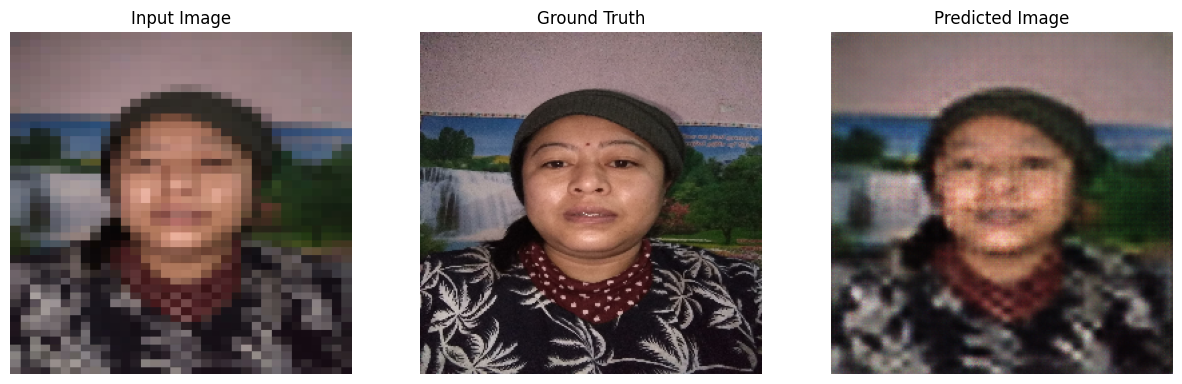

Step: 39k
....................................................................................................

In [55]:
fit(train_dataset, test_dataset, steps=40000)   #40000 for normal BATCH_SIZE = 1 dataset=330张图片 一个epoch=330 个step，80000=240+ epoches

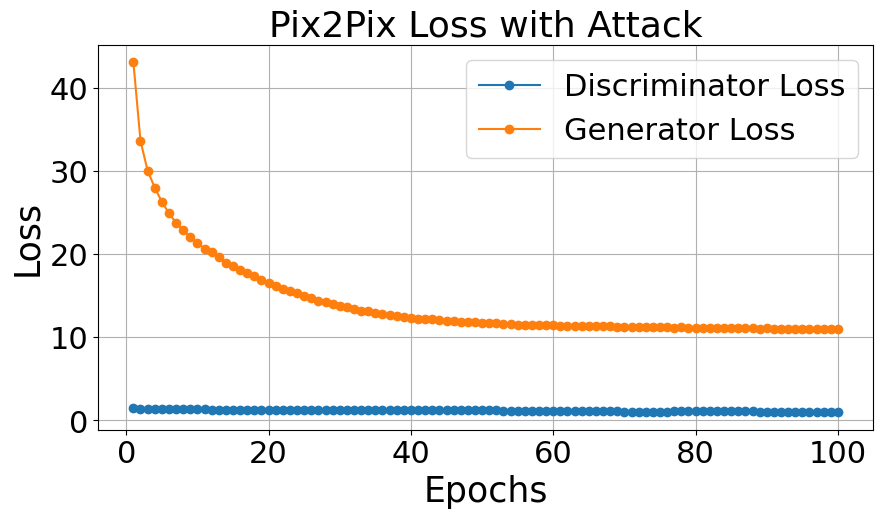

In [56]:
# 计算生成器和判别器的平均损失（只计算前 50 个 epoch）
import numpy as np
steps_per_epoch = 300
# 最大 epoch 数
max_epoch = 100

# 计算生成器和判别器的平均损失（只针对前 max_epoch）
gen_avg_loss_per_epoch = [np.mean(gen_total_loss_list[i * steps_per_epoch:(i + 1) * steps_per_epoch])
                          for i in range(max_epoch)]
disc_avg_loss_per_epoch = [np.mean(disc_loss_list[i * steps_per_epoch:(i + 1) * steps_per_epoch])
                           for i in range(max_epoch)]

# 绘制按 epoch 计算的损失曲线
plt.figure(figsize=(10, 5))

# 绘制生成器和判别器的损失，添加 marker
plt.plot(range(1, max_epoch + 1), disc_avg_loss_per_epoch, label="Discriminator Loss", marker='o')
plt.plot(range(1, max_epoch + 1), gen_avg_loss_per_epoch, label="Generator Loss", marker='o')


# 添加标题、坐标轴标签和图例，调整字体大小
plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Loss", fontsize=25)
plt.title("Pix2Pix Loss with Attack", fontsize=26)
plt.legend(fontsize=22)

# 添加网格
plt.grid(True)

# 调整刻度字体大小
plt.tick_params(axis='both', which='major', labelsize=22)

# 保存图像
plt.savefig("loss_plot.png")

# 显示图像
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


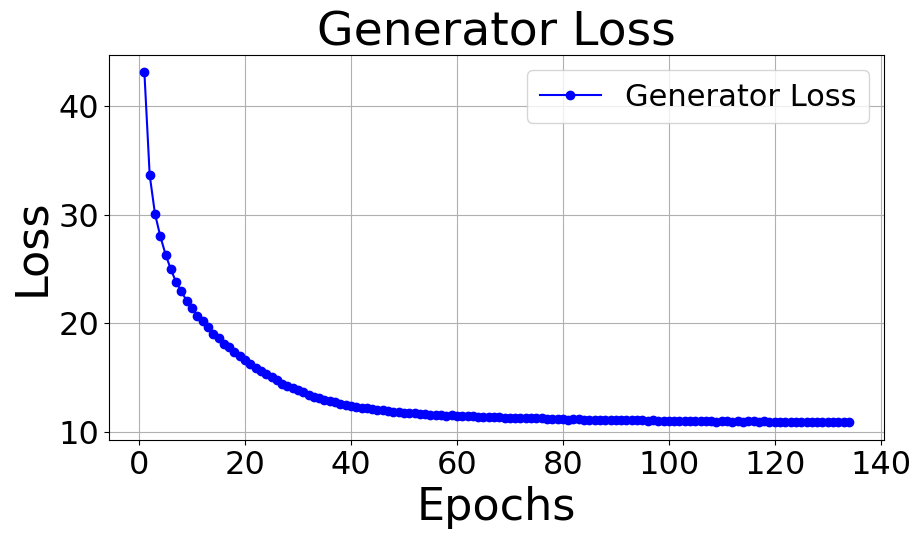

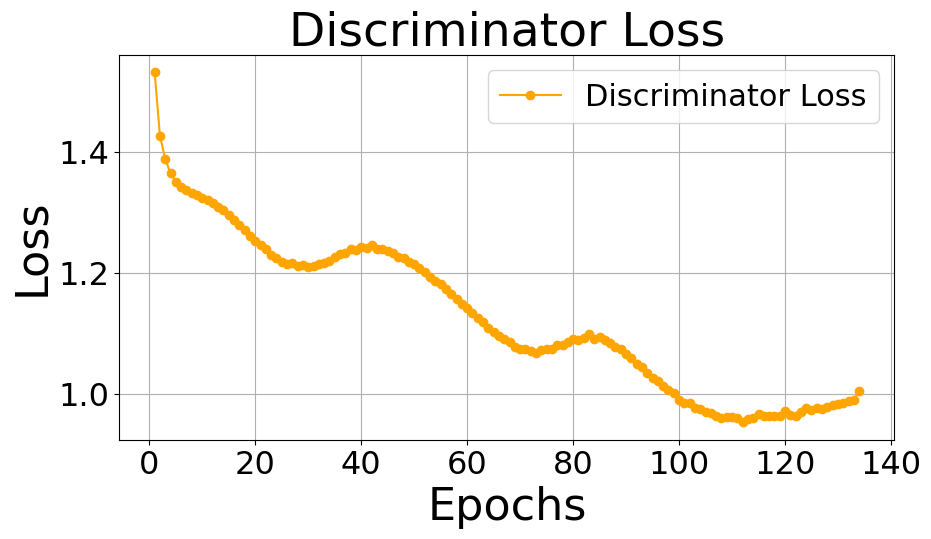

In [57]:
# 计算生成器和判别器的平均损失（只计算前 100 个 epoch）
import numpy as np
steps_per_epoch = 300
max_epoch = 500

# 计算生成器和判别器的平均损失（只针对前 max_epoch）
gen_avg_loss_per_epoch = [np.mean(gen_total_loss_list[i * steps_per_epoch:(i + 1) * steps_per_epoch])
                          for i in range(max_epoch)]
disc_avg_loss_per_epoch = [np.mean(disc_loss_list[i * steps_per_epoch:(i + 1) * steps_per_epoch])
                           for i in range(max_epoch)]

# 绘制生成器损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epoch + 1), gen_avg_loss_per_epoch, label="Generator Loss", marker='o', color='blue')
plt.xlabel("Epochs", fontsize=32)
plt.ylabel("Loss", fontsize=32)
plt.title("Generator Loss", fontsize=34)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=22)
plt.savefig("generator_loss_plot.png")
plt.show()

# 绘制判别器损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epoch + 1), disc_avg_loss_per_epoch, label="Discriminator Loss", marker='o', color='orange')
plt.xlabel("Epochs", fontsize=32)
plt.ylabel("Loss", fontsize=32)
plt.title("Discriminator Loss", fontsize=34)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=22)
plt.savefig("discriminator_loss_plot.png")
plt.show()


与简单的分类或回归模型相比，在训练 GAN（或像 pix2pix 这样的 cGAN）时，对日志的解释更加微妙。要检查的内容包括：

- 检查生成器模型或判别器模型均未“获胜”。如果 `gen_gan_loss` 或 `disc_loss` 变得很低，则表明此模型正在支配另一个模型，并且您未能成功训练组合模型。
- 值 `log(2) = 0.69` 是这些损失的一个良好参考点，因为它表示困惑度为 2：判别器对这两个选项的平均不确定性是相等的。
- 对于 `disc_loss`，低于 `0.69` 的值意味着判别器在真实图像和生成图像的组合集上的表现要优于随机数。
- 对于 `gen_gan_loss`，如果值小于 `0.69`，则表示生成器在欺骗判别器方面的表现要优于随机数。
- 随着训练的进行，`gen_l1_loss` 应当下降。

## 恢复最新的检查点并测试网络

In [58]:
!ls {checkpoint_dir}

checkpoint		     ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-10.data-00000-of-00001  ckpt-2.index		 ckpt-7.data-00000-of-00001
ckpt-10.index		     ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-11.data-00000-of-00001  ckpt-3.index		 ckpt-8.data-00000-of-00001
ckpt-11.index		     ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-12.data-00000-of-00001  ckpt-4.index		 ckpt-9.data-00000-of-00001
ckpt-12.index		     ckpt-5.data-00000-of-00001  ckpt-9.index
ckpt-1.data-00000-of-00001   ckpt-5.index
ckpt-1.index		     ckpt-6.data-00000-of-00001


In [59]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 使用测试集生成一些图像

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
import os
from PIL import Image
import numpy as np

# 定义输出文件夹，与 images_dataset 同级
output_dir = 'testdataset_predict_result_attacked'
os.makedirs(output_dir, exist_ok=True)

# 使用 enumerate 对 test_dataset 进行遍历，i 用于给输出文件命名
for i, (inp, tar) in enumerate(test_dataset):
    # 使用生成器对输入图像进行预测
    prediction = generator(inp, training=True)  # prediction 的形状为 (1, 256, 256, 3)

    # 将 [-1, 1] 范围的像素值转换回 [0, 255]
    pred_img = (prediction[0].numpy() * 0.5 + 0.5)*255
    pred_img = pred_img.astype(np.uint8)

    # 保存预测结果到指定文件夹
    save_path = os.path.join(output_dir, f"pred_{i}.jpg")
    Image.fromarray(pred_img).save(save_path)

    print(f"Saved: {save_path}")


In [ ]:
import os
from PIL import Image
import numpy as np

# 定义输出文件夹，与 images_dataset 同级
gt_output_dir = 'testdataset_predict_ground_truth_attacked'
os.makedirs(gt_output_dir, exist_ok=True)

# 遍历 test_dataset (其中每个元素为 (inp, tar))
for i, (inp, tar) in enumerate(test_dataset):
    # tar 为真实的目标图像，范围为 [-1, 1]
    # 将 [-1, 1] 映射回 [0, 255]
    gt_img = (tar[0].numpy() * 0.5 + 0.5)*255
    gt_img = gt_img.astype(np.uint8)

    # 保存真实图像到指定文件夹
    save_path = os.path.join(gt_output_dir, f"gt_{i}.jpg")
    Image.fromarray(gt_img).save(save_path)

    print(f"Saved ground truth image: {save_path}")
